# ALeRCE testing different periodograms

```Authors: Francisco Förster, Alejandra Muñoz Arancibia, Ignacio Reyes Jainaga. Last updated: 20251009```

ALeRCE starter notebook for periodogram tests using the alerce client and the P4J package.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ALeRCE_Other_Periodograms.ipynb).*
This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system.

In [1]:
# Set cell width to 100%
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B', 3: 'gold'}

## Requirements

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We provide a Python client for easier access to the ALeRCE API services. It can be installed via pip and is documented in https://alerce.readthedocs.io/en/latest/. Uncomment in case you need to install.

In [4]:
#!pip install alerce
from alerce.core import Alerce
client = Alerce()

Note that this notebook uses the ALeRCE version of P4J (https://pypi.org/project/P4J/), which can be cloned and installed from https://github.com/alercebroker/pipeline/tree/main/P4J

In [5]:
#!git clone https://github.com/alercebroker/pipeline.git
#!cd pipeline/P4J && pip install . -r requirements.txt

In [6]:
import P4J

## Functions for obtaining periods, plotting light curves and querying one target

In [7]:
# for the moment use the g band
def doperiod(LCdet, method):

    objperiod = {}
    freq = {}
    per = {}
    for fid in LCdet.fid.unique():
        maskdet = LCdet.fid == fid
        mjds, mags, errs = LCdet[['mjd', 'magpsf_corr',
                                  'sigmapsf_corr_ext']][maskdet].dropna().values.T
        
        my_per = P4J.periodogram(method=method) # 'PDM1', 'LKSL', 'MHAOV', 'QMICS', 'QMIEU'
        my_per.set_data(np.array(mjds), np.array(mags), np.array(errs))
        my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-5)
        my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=1)#10)              
        freq[fid], per[fid] = my_per.get_periodogram()
        fbest, pbest = my_per.get_best_frequencies()
        objperiod[fid] = 1. / fbest
        print(fid, objperiod[fid])

    period = objperiod[1]
    
    return period, freq, per

In [8]:
def plotLC(oid, LCdet, LCnondet, dofold, period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r', 3: 'i'}
    for idx, fid in enumerate(LCdet.fid.unique()):
        maskdet = LCdet.fid == fid
        masknondet = (LCnondet.fid == fid) & (LCnondet.diffmaglim > -900)
        
        if dofold:
            phase = np.mod(LCdet[maskdet].mjd, period) / period
            for nphase in [0, 1]:
                ax.errorbar(phase + nphase, LCdet[maskdet].magpsf_corr, 
                            yerr=LCdet[maskdet].sigmapsf_corr_ext, c=colors[fid],
                            marker='o', label=labels[fid], lw=0)
        else:
            ax.errorbar(LCdet[maskdet].mjd, LCdet[maskdet].magpsf_corr, 
                        yerr=LCdet[maskdet].sigmapsf_corr_ext, c=colors[fid],
                        marker='o', label=labels[fid])
            ax.scatter(LCnondet[masknondet].mjd, LCnondet[masknondet].diffmaglim,
                       c=colors[fid], alpha=0.5, marker='v',
                       label='lim.mag. %s' % labels[fid])
    if dofold:
        ax.set_title('%s (period: %.3f days)' % (oid, period))
        ax.set_xlabel('phase')
    else:
        ax.set_title(oid)
        ax.set_xlabel('MJD')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold:
        fig, ax = plt.subplots(ncols=len(LCdet.fid.unique()), figsize=(12, 4))
        for idx, fid in enumerate(LCdet.fid.unique()):
            ax_i = ax if len(LCdet.fid.unique()) == 1 else ax[idx]
            ax_i.plot(freq[fid], per[fid])
            ax_i.set_title('Periodogram %s' % labels[fid])
            ax_i.set_xlabel('frequency [1/days]')

In [9]:
def getLCdata(oid, doplot=False, dofold=False):

    # query detections
    LCdet = client.query_detections(oid, format='pandas')
    LCdet.sort_values(by=['mjd'], inplace=True)
        
    # query non detections
    LCnondet = client.query_non_detections(oid, format='pandas')
    LCnondet.sort_values(by=['mjd'], inplace=True)

    if dofold:
        # get period
        period, freq, per = doperiod(LCdet, 'PDM1')
    else:
        period = None; freq = None; per = None  
    
    if doplot:
        plotLC(oid, LCdet, LCnondet, dofold, period=period, freq=freq, per=per)
        
    # return data
    return LCdet, LCnondet

## Testing different periodograms for a given object

For this example, we selected a difficult eclipsing binary star system, CSS_J031528.0-122537 in the Catalina Surveys Data Release 2. The name of this system in the ZTF is ZTF18abuamei. Note that its light curve and the properties of this system can also be accessed through the ALeRCE Explorer: https://alerce.online/object/ZTF18abuamei.

ZTF18abuamei


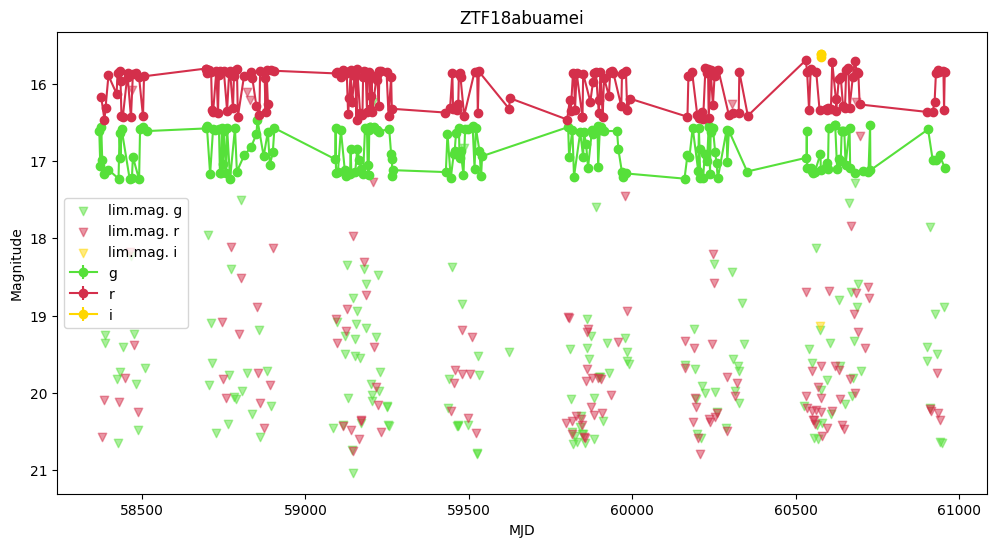

In [10]:
seloid = 'ZTF18abuamei'
print(seloid)
LCdet, LCnondet = getLCdata(seloid, doplot=True, dofold=False);

PDM1
1 [0.2653069]


2 [0.2653083]
3 []
LKSL
1 [0.2653083]


2 [0.2653083]
3 []
MHAOV
1 [0.2206064]


2 [0.22060786]
3 []
QMICS
1 [0.22060739]
2 [0.2206064]
3 [0.42858857]
QMIEU
1 [0.22060739]
2 [0.2206064]
3 [0.23781836]


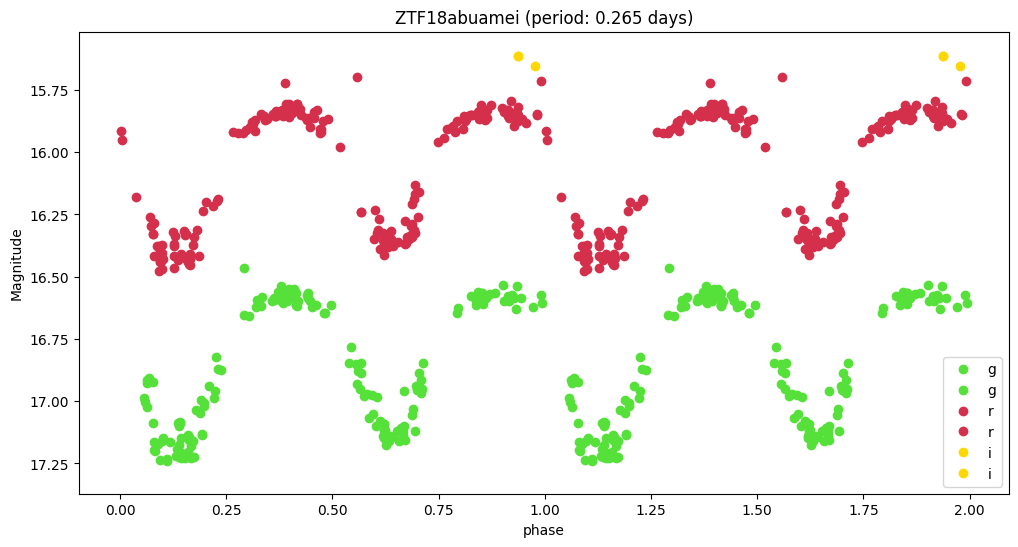

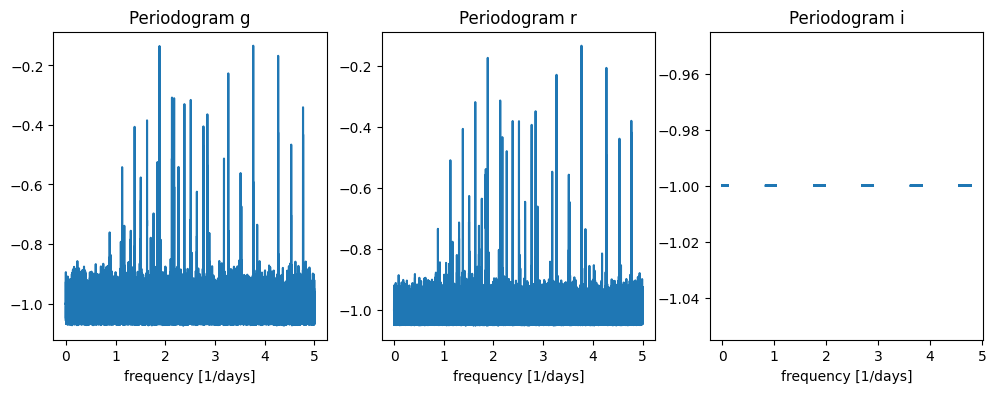

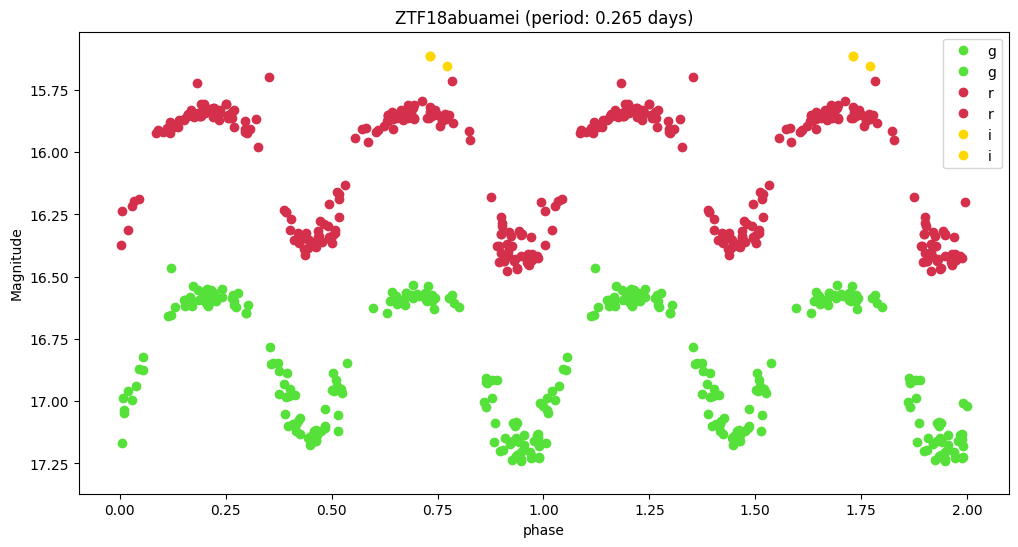

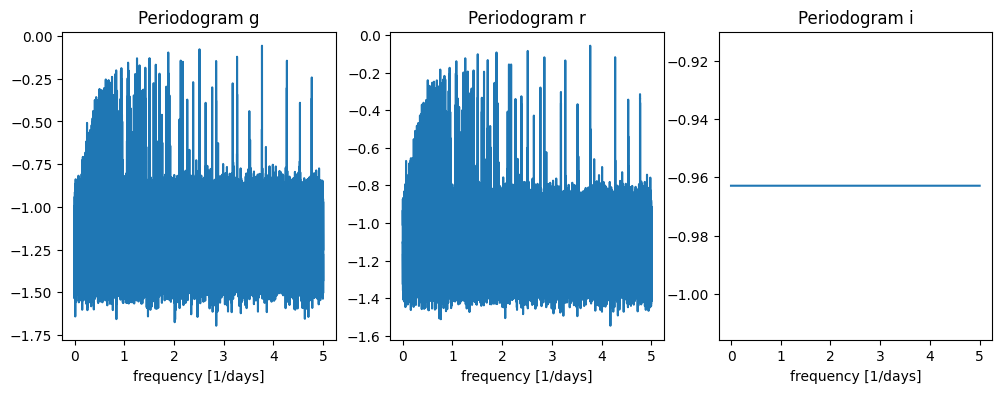

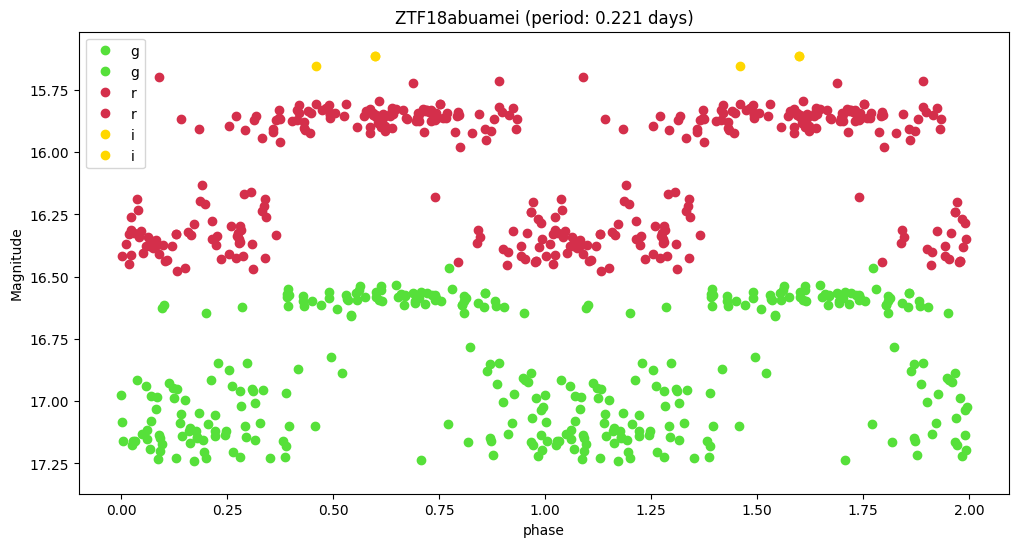

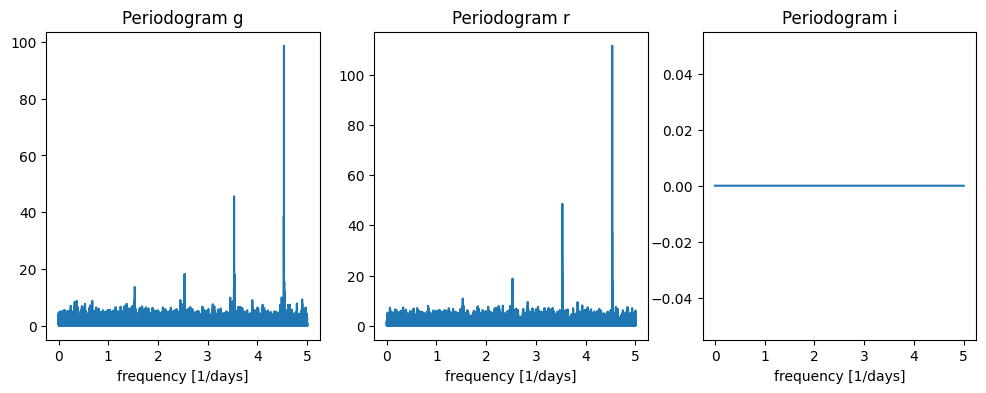

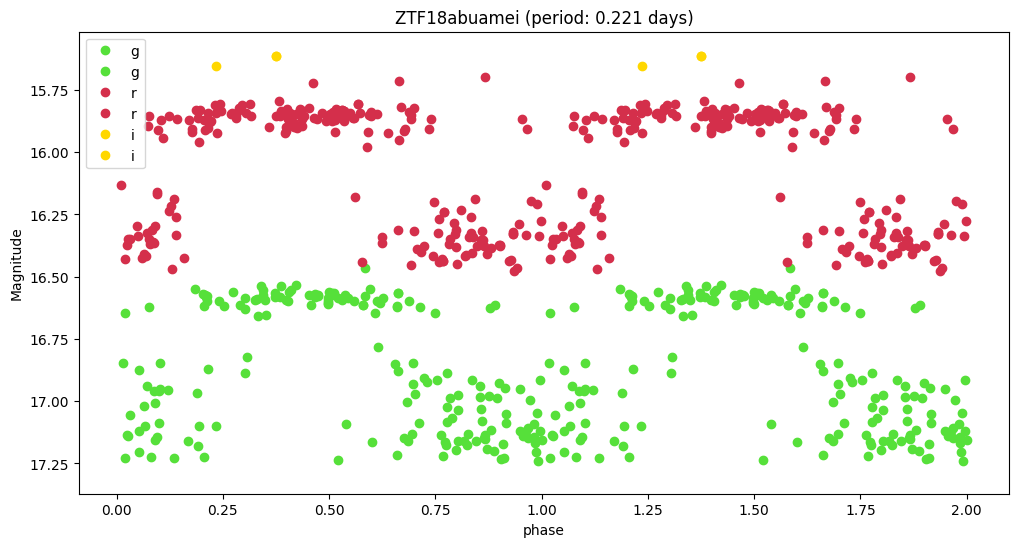

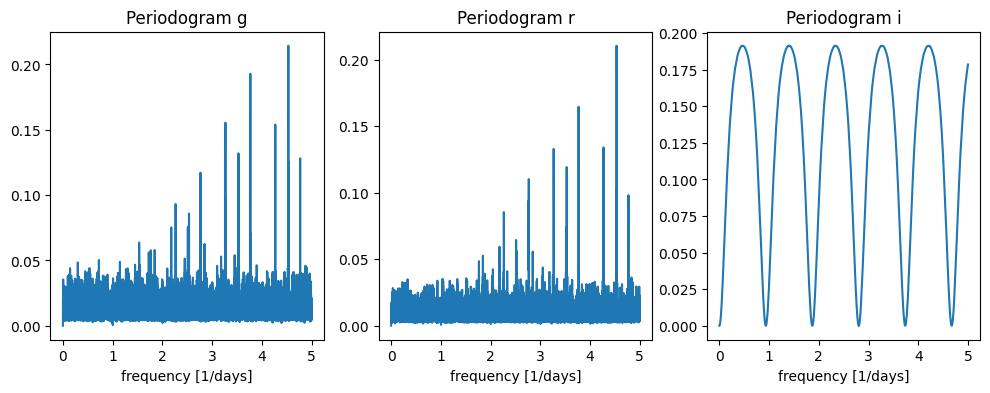

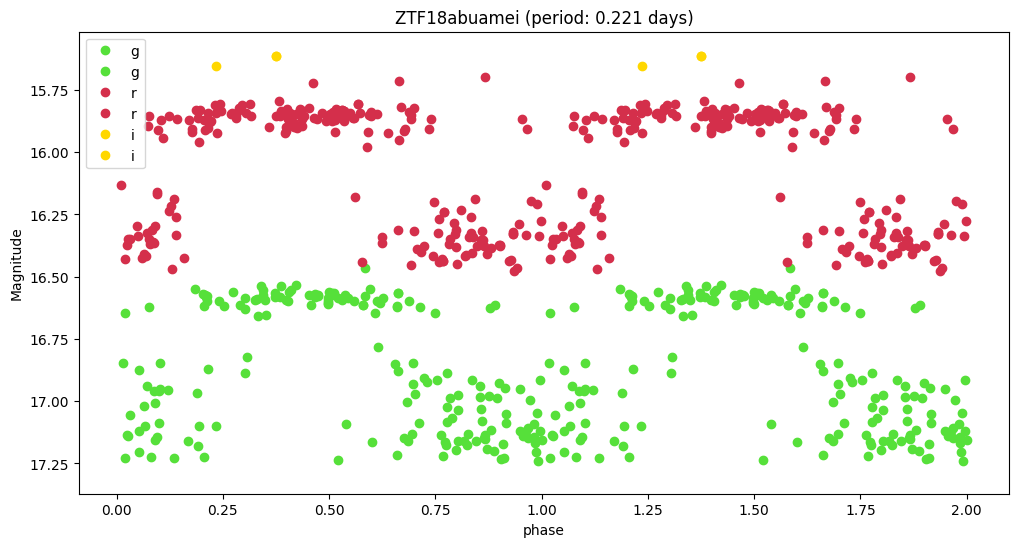

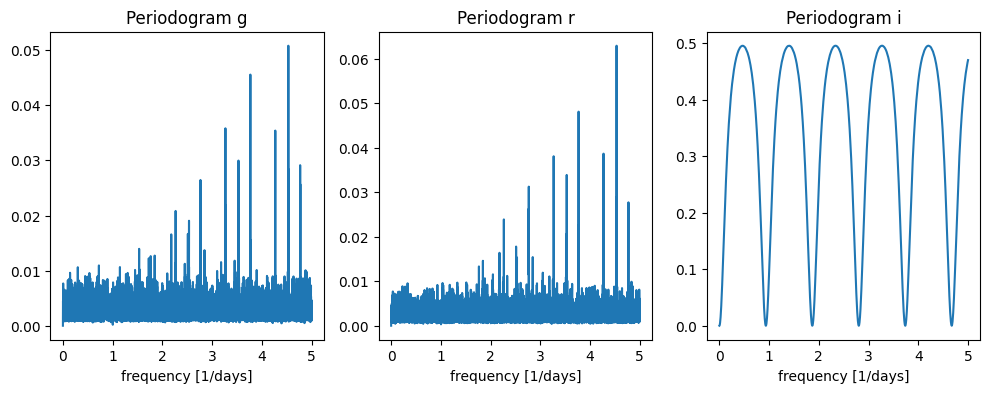

In [11]:
for method in ['PDM1', 'LKSL', 'MHAOV', 'QMICS', 'QMIEU']:
    print(method)
    period, freq, per = doperiod(LCdet, method)
    plotLC(seloid, LCdet, LCnondet, True, period=period[0], freq=freq, per=per)

### Normalize the bands

In [12]:
mask_g = LCdet.fid == 1
mask_r = LCdet.fid == 2

# mean and standard deviation
offset_g = LCdet.loc[mask_g].magpsf_corr.mean()
width_g = LCdet.loc[mask_g].magpsf_corr.std()
offset_r = LCdet.loc[mask_r].magpsf_corr.mean()
width_r = LCdet.loc[mask_r].magpsf_corr.std()

# median and interquartile range
#offset_g = LCdet.loc[mask_g].magpsf_corr.median()
#width_g = LCdet.loc[mask_g].magpsf_corr.quantile(0.75) - LCdet.loc[mask_g].magpsf_corr.quantile(0.25)
#offset_r = LCdet.loc[mask_r].magpsf_corr.mean()
#width_r = LCdet.loc[mask_r].magpsf_corr.quantile(0.75) - LCdet.loc[mask_r].magpsf_corr.quantile(0.25)

In [13]:
LCdet['magpsf_normed'] = LCdet.apply(lambda row: (row.magpsf_corr - offset_g) / width_g if 
                                     row.fid == 1 else (row.magpsf_corr - offset_r) / width_r, axis=1)
LCdet['sigmapsf_normed'] = LCdet.apply(lambda row: row.sigmapsf_corr_ext / width_g if 
                                       row.fid == 1 else row.sigmapsf_corr_ext / width_r, axis=1)

In [14]:
LCdet.head()

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,...,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid,magpsf_normed,sigmapsf_normed
0,ztf,58369.460810,615460810415015021,1,615460810415,20.673506,1,615,0.251231,19.124279,...,0.1387,351120104.0,False,True,False,bulk_1.0.0,0.0,6.313176e+17,-1.010662,0.064493
1,ztf,58372.447014,618447010415010018,1,618447010415,20.680912,-1,618,0.090683,18.169577,...,0.0445,351120104.0,False,True,False,bulk_1.0.0,0.0,6.313176e+17,0.767002,0.131365
2,ztf,58375.443762,621443760415015014,1,621443760415,20.667350,1,621,0.254581,18.698767,...,0.0943,351120104.0,False,True,False,bulk_1.0.0,0.0,6.313176e+17,-1.210822,0.073716
3,ztf,58375.484919,621484910415010006,2,621484910415,20.407394,-1,621,0.097113,18.375534,...,0.0796,351120204.0,False,True,False,bulk_1.0.0,0.0,6.313176e+17,0.456324,0.040199
4,ztf,58378.443727,624443720415010016,1,624443720415,20.750930,-1,624,0.175001,18.401123,...,0.0644,351120104.0,False,True,False,bulk_1.0.0,0.0,6.313176e+17,0.478111,0.070813


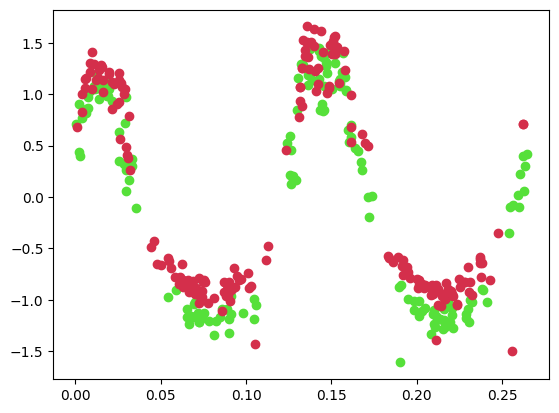

In [15]:
myperiod = 0.26530758 # this is the correct period for ZTF18abuamei
fig, ax = plt.subplots()
ax.scatter(np.mod(LCdet.loc[mask_g].mjd, myperiod), LCdet.loc[mask_g].magpsf_normed, c=colors[1])
ax.scatter(np.mod(LCdet.loc[mask_r].mjd, myperiod), LCdet.loc[mask_r].magpsf_normed, c=colors[2])

### Now we will fool the previous code and see what happens when we use all the points as if one band

In [16]:
LCnorm = LCdet[['mjd', 'magpsf_normed', 'sigmapsf_normed']].copy()

In [17]:
LCnorm.rename({'magpsf_normed': 'magpsf_corr', 'sigmapsf_normed': 'sigmapsf_corr_ext'},
              inplace=True, axis=1)

In [18]:
LCnorm['fid'] = 1

### And try again

PDM1
1 [0.265309]
LKSL
1 [0.2653076]
MHAOV
1 [0.22060739]
QMICS
1 [0.2206069]
QMIEU
1 [0.2206069]


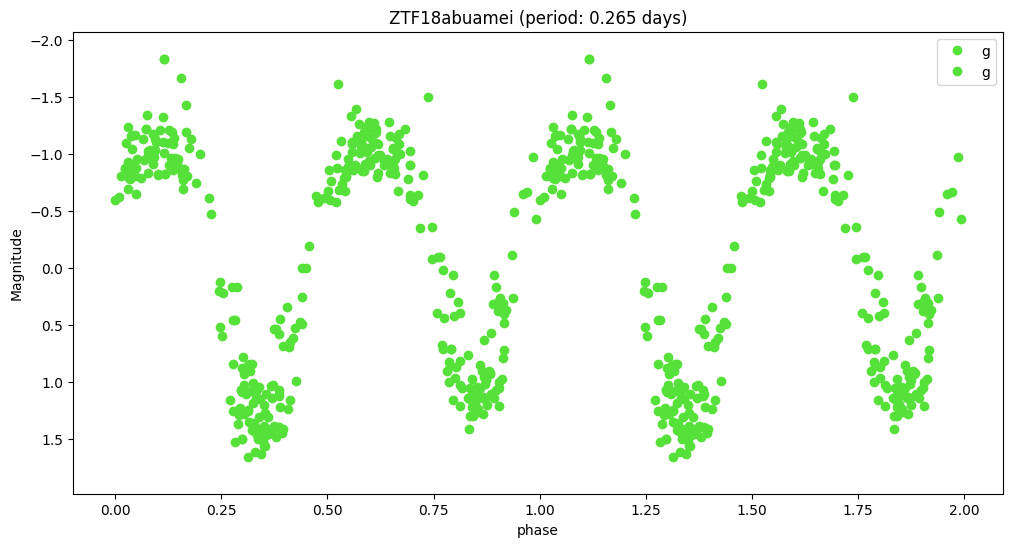

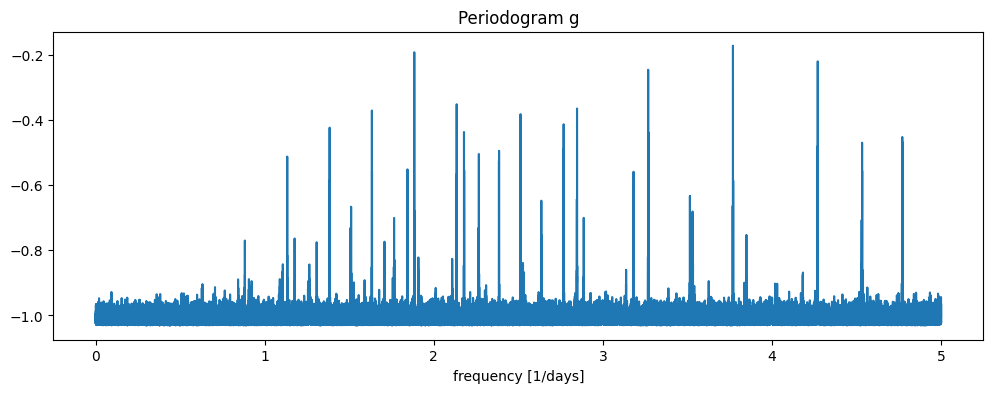

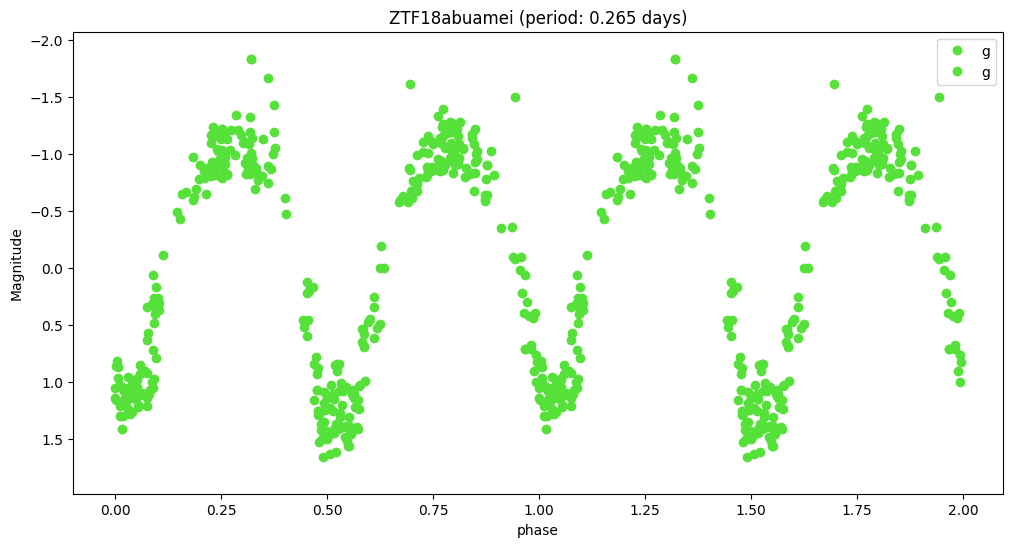

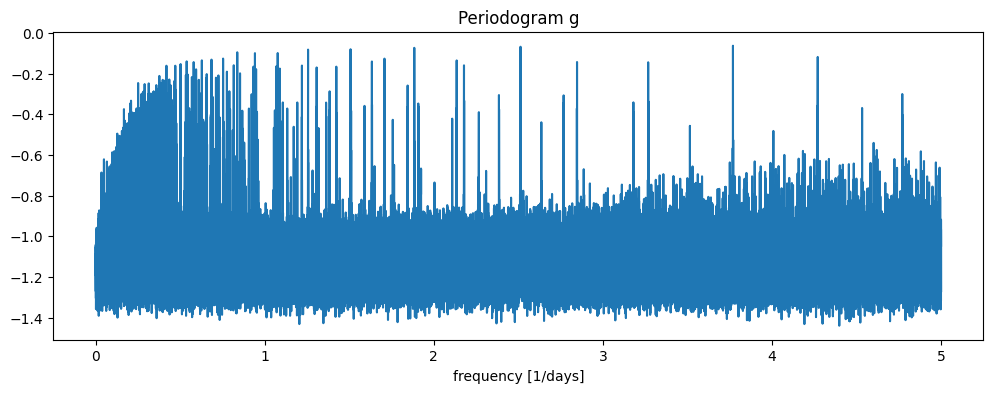

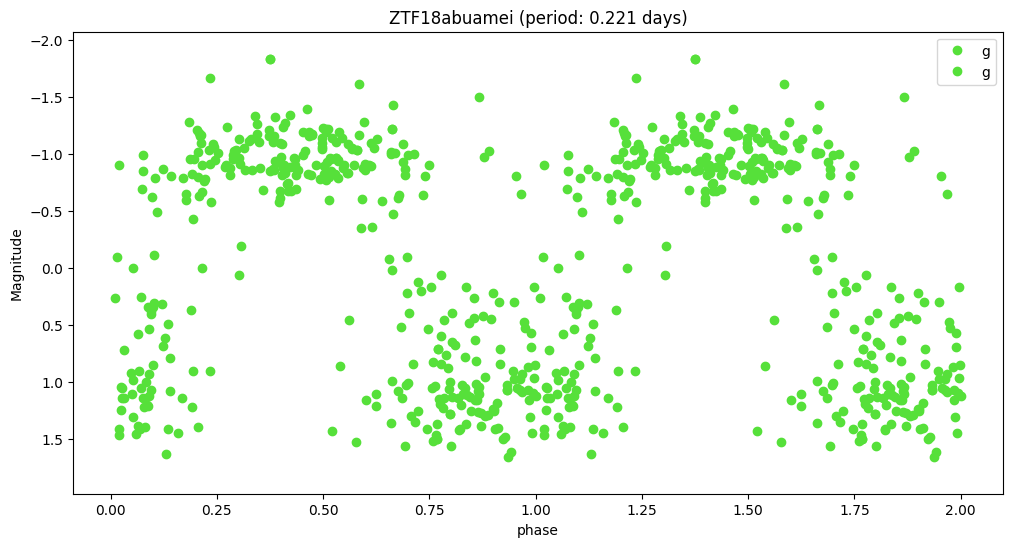

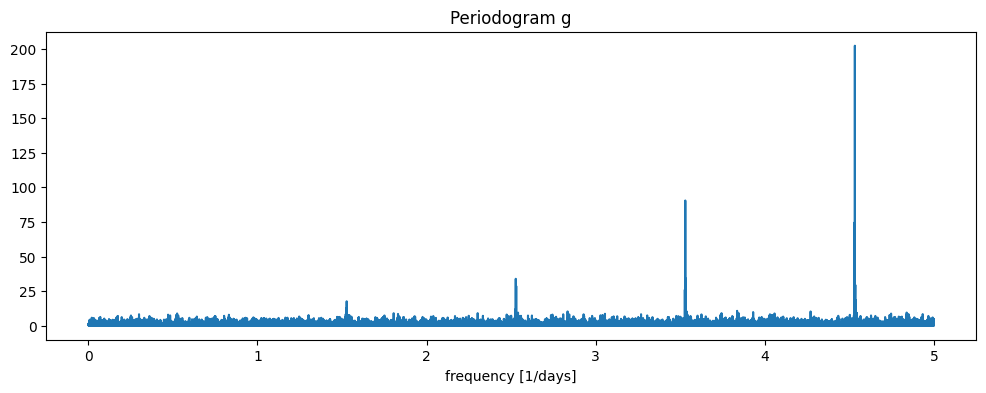

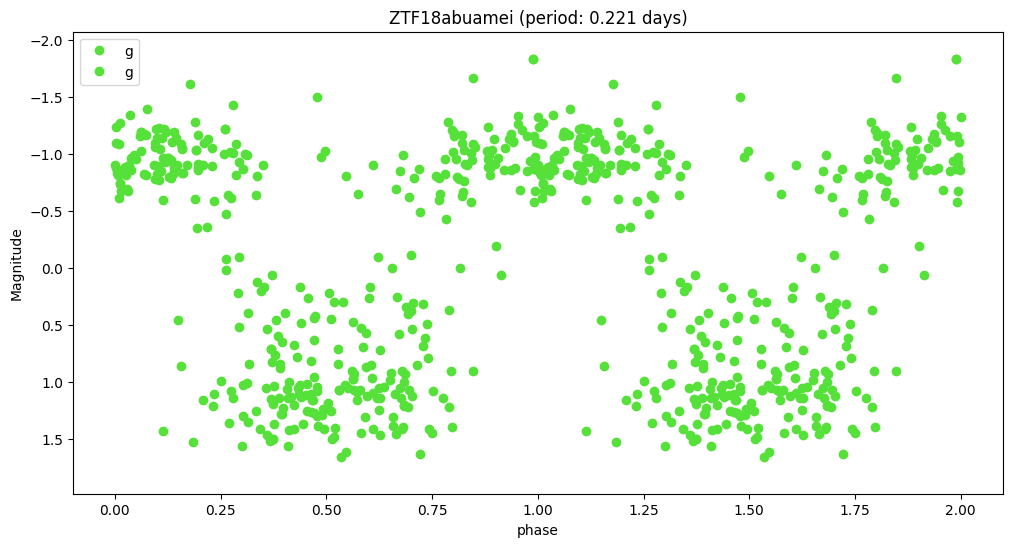

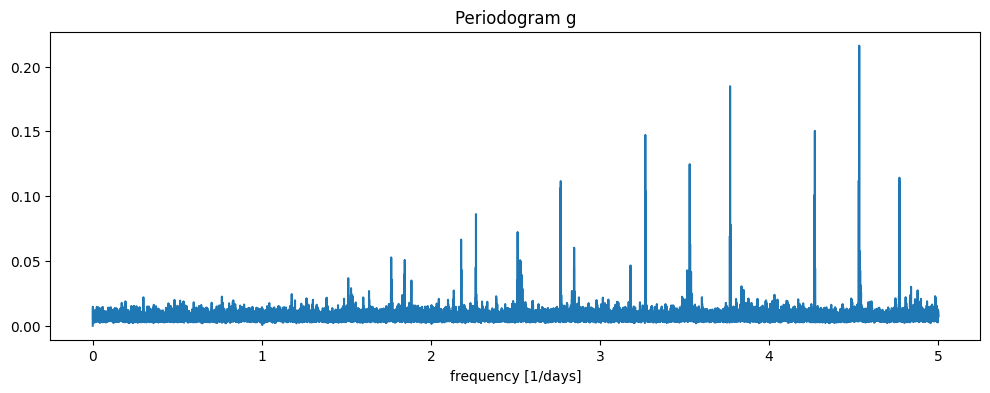

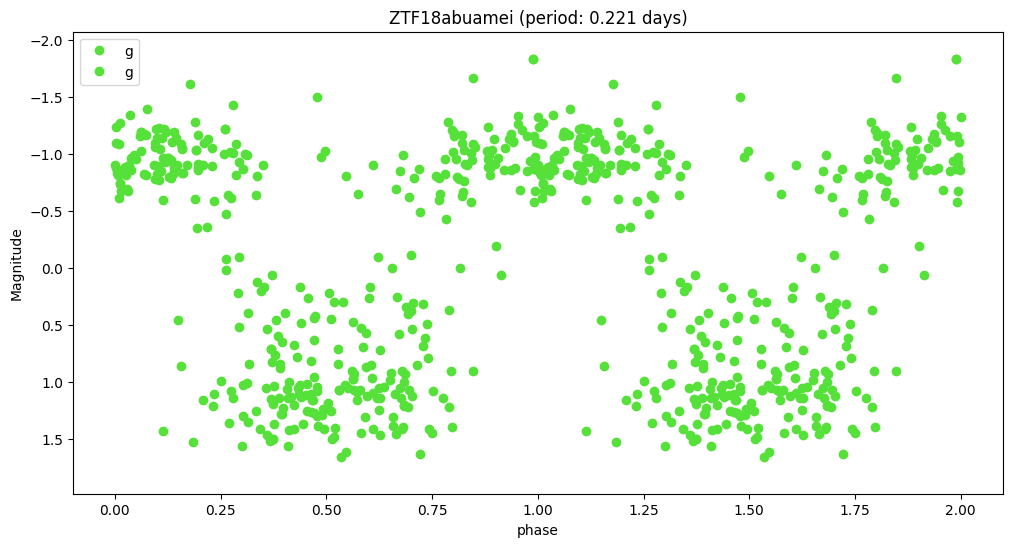

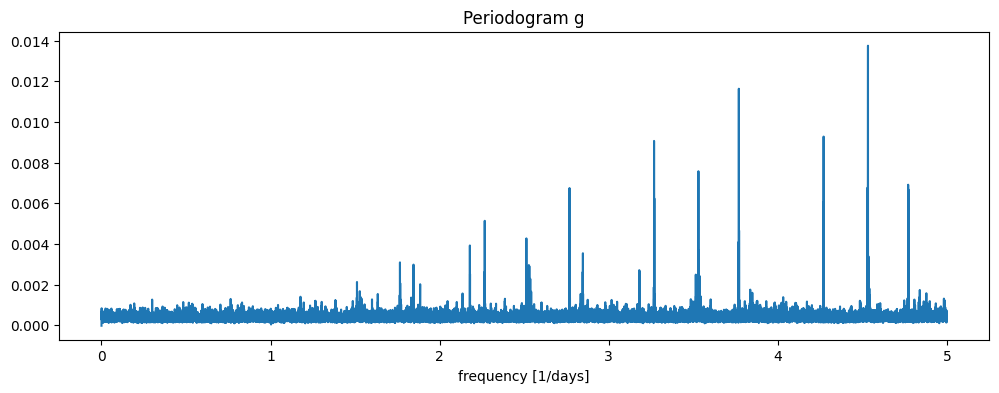

In [19]:
for method in ['PDM1', 'LKSL', 'MHAOV', 'QMICS', 'QMIEU']:
    print(method)
    period, freq, per = doperiod(LCnorm, method)
    plotLC(seloid, LCnorm, LCnondet, True, period=period[0], freq=freq, per=per)